# Classification using BERT

## Getting started

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import re
import tokenization
import string

from src.utils.bert_utils import *

In [20]:
filename = 'clean_entire_corpus.csv'

df = pd.read_csv(filename)
train = df[df['source'] == 'train'].copy()
test = df[df['source'] == 'test'].copy()

## Data preprocessing

* Loading BERT from Tensorhub

In [23]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

* Loading BERT's tokenizer

In [24]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

* Encode texts to BERT's input

In [21]:
def bert_encode(texts, tokenizer, max_len=512):
    """ Encode sequence of texts into bert's input"""
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [25]:
max_len = 40
train_input = bert_encode(train['clean_text'].values, tokenizer, max_len=max_len)
test_input = bert_encode(test['clean_text'].values, tokenizer, max_len=max_len)
train_labels = train['target'].values
test_labels = test['target'].values

## Training model

In [22]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    # Get and save embeddings later
    sub_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=clf_output)
    
    return model, sub_model

In [26]:
model, submodel = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 40)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 40)]         0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [27]:
train_history = model.fit(
    train_input, train_labels,
    epochs=1,
    batch_size=14,
    validation_data=(test_input, test_labels),
)

489/489 [==============================] - 517s 1s/step - loss: 0.4374 - accuracy: 0.8101 - val_loss: 0.3967 - val_accuracy: 0.8287


* Save BERT's input for later usage

In [ ]:
train_embeddings = submodel.predict(train_input)
test_embeddings = submodel.predict(test_input)

In [ ]:
import pickle

with open("./data/embeddings_train.pkl", 'wb') as f:
    pkl.dump(train_embeddings, f)
    
with open("./data/embeddings_test.pkl", 'wb') as f:
    pkl.dump(test_embeddings, f)

## Visualize tweets through BERT's embeddings

In [10]:
with open('./data/embeddings_train.pkl', 'rb') as f:
    train_embeddings = pkl.load(f)
    
with open('./data/embeddings_test.pkl', 'rb') as f:
    test_embeddings = pkl.load(f)
    
# Import labels
df = pd.read_csv('./data/clean_entire_corpus.csv')
y_train = df[df['source'] == 'train']['target']

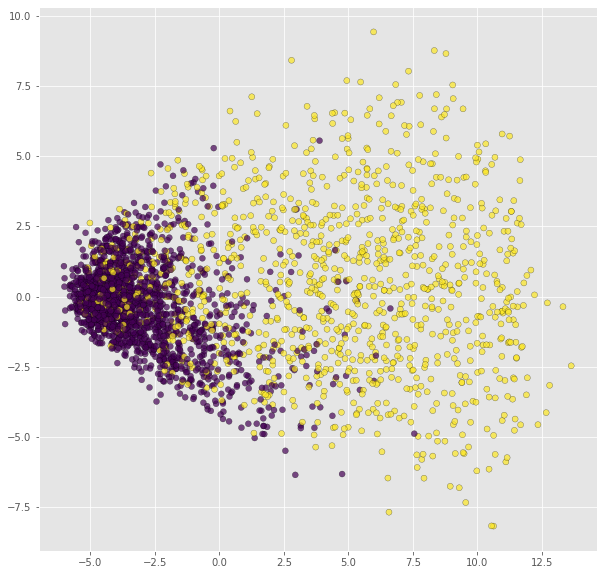

In [11]:
# Plotting BERT's embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pca = PCA(2)
twodim = pca.fit_transform(train_embeddings)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
colors = y_train
n = 3000
ax.scatter(twodim[:n,0], twodim[:n,1], c=colors[:n], alpha=.7, linewidth=.3, edgecolor='black')